In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import models_v42 as wearmodels
from wearables.scripts import train_v42 as weartrain
from wearables.scripts import eval_v42 as weareval

import torch

import numpy as np

In [2]:
# model
# net = wearmodels.InceptionTime(2, 1, bottleneck=8, kernel_size=5,
#                                nb_filters=512, residual=True, nb_layers=16)
net = wearmodels.LSTM(2, 256, 8, 10080, 1)

# double chk size
print(wearutils.estimate_model_mem(net))

16 MB


In [3]:
trainer = weartrain.train(net,  
                          load_splits=None,
                          n_epochs=5000,
                          batch_size=32,
                          lr=1e-6,
                          device=torch.device('cuda:0'))

In [4]:
trainer.fit()


Starting training after 6-s of setup...


/home/ngrav/project/wearables/scripts/train_v42.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, dtype=torch.float)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
evaluation = weareval.eval_trained(trainer, 
                                   out_file='/home/ngrav/project/wearables/results/eval_test_v42.csv')

# dev

In [11]:
# test
device = torch.device('cpu')
trainer.model.to(device)
trainer.model.eval()
if True: # switch for set to analyze
    dataloader = trainer.data.test_dl

for i, batch in enumerate(dataloader):
    x, y, idx = batch['x'], batch['y'], batch['id']

    output = trainer.model(x)
    if trainer.data.tasktype == 'regression':
        output = output.squeeze()
    if i==0:
        y_total = y.detach()
        idx_total = idx
        yhat_total = output.detach()
    else:
        y_total = torch.cat((y_total, y.detach()), dim=0)
        idx_total = idx_total + idx
        yhat_total = torch.cat((yhat_total, output.detach()), dim=0)
loss_test = trainer.criterion(yhat_total, y_total).item()

In [12]:
loss_test

88.0103988647461

In [18]:
(y_total - yhat_total).abs().mean().item()

8.121149063110352

In [19]:
from scipy.stats import spearmanr

In [21]:
spearmanr(y_total, yhat_total)

SpearmanrResult(correlation=0.3109129103839624, pvalue=2.995345883681129e-18)

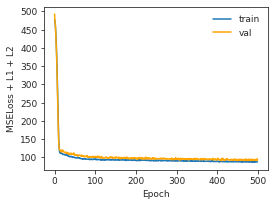

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(np.arange(len(trainer.loss)), trainer.loss, label='train')
ax.plot(np.arange(len(trainer.loss_val)), trainer.loss_val, label='val', color='orange')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('MSELoss + L1 + L2')
fig.savefig('/home/ngrav/project/wearables/results/CNN_GA_0_losscurves.png')

In [29]:
trainer.model

CNN(
  (vgg): Sequential(
    (0): Sequential(
      (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
 

In [33]:
trainer.model.to(torch.device('cuda:0'))

CNN(
  (vgg): Sequential(
    (0): Sequential(
      (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
 

In [34]:
trainer.model = trainer.model.to(torch.device('cuda:0'))

In [37]:
torch.save(trainer.model.state_dict(), '/home/ngrav/scratch/test.pkl')

In [38]:
trainer.model.load_state_dict(torch.load('/home/ngrav/scratch/test.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

In [77]:
import importlib
importlib.reload(weareval)

<module 'wearables.scripts.eval_v42' from '/home/ngrav/project/wearables/scripts/eval_v42.py'>

In [78]:
from wearables.scripts import eval_v42 as weareval
evaluation = weareval.eval_trained(trainer, 
                                   out_file='/home/ngrav/project/wearables/results/eval_test_v42.csv')

In [65]:
evaluation.results

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,edinb4_1trim,edinb5_1trim,edinb6_1trim,edinb7_1trim,edinb8_1trim,edinb9_1trim,edinb10_1trim,id,y,yhat
0,1620.0,34.0,0.0,4.0,3.0,0.0,1.0,29.280067,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1620_8,tensor(8.),tensor(19.4009)
1,2174.0,22.0,1.0,2.0,3.0,0.0,0.0,28.575377,0.0,1.0,...,3.0,3.0,3.0,1.0,1.0,1.0,1.0,2174_24,tensor(24.),tensor(21.9032)
2,1126.0,18.0,0.0,1.0,1.0,0.0,0.0,54.132374,0.0,0.0,...,3.0,2.0,3.0,3.0,2.0,3.0,1.0,1126_10,tensor(10.),tensor(19.1752)
3,2278.0,29.0,1.0,2.0,3.0,0.0,0.0,23.683273,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2278_10,tensor(10.),tensor(17.8081)
4,2311.0,18.0,0.0,2.0,3.0,0.0,1.0,35.355957,0.0,0.0,...,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2311_22,tensor(22.),tensor(21.0674)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,2488.0,36.0,0.0,2.0,3.0,0.0,0.0,37.115395,0.0,1.0,...,4.0,1.0,3.0,1.0,2.0,2.0,1.0,2488_34,tensor(34.),tensor(20.4559)
745,1319.0,32.0,0.0,1.0,1.0,0.0,1.0,37.401787,0.0,0.0,...,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1319_10,tensor(10.),tensor(19.5485)
746,1774.0,28.0,1.0,3.0,3.0,0.0,1.0,21.298285,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1774_7,tensor(7.),tensor(21.5935)
747,2528.0,32.0,1.0,2.0,3.0,0.0,0.0,19.222656,0.0,0.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2528_22,tensor(22.),tensor(23.7955)


In [67]:
trainer.exp

'CNN_GA'